# Physics Informed Neural Network: 



1.   we have been given a differential eqaution of second order with a degree one as follows:
$$u_{xx} - f(x) = 0$$


2.   the domain defined is $[0, 1]$ and we have given the boundary conditions as follows:

$$u(0) = 0 \text{, } u(1) = 0$$



let us take 100 points in the given domain to define the physics (number of collocation points $N_x$) and then if we try to write the expression for the loss function for the problem then we have: 

$$L = \frac{1}{N_x} \sum r_x^2 + \alpha \{f_1^2(0) + f_1^2(1)\}$$


where $\alpha$ is a hyper-paramter for the model, the larger the value of the hyper-parameter the more strictly will boundary conditions be followed. 

In [ ]:
import scipy
import numpy as np
import tensorflow as tf
from scipy import optimize
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [ ]:
class Network:
  @classmethod
  def build(cls, num_inputs=1,layers=[16,32,64],activation='tanh', num_outputs=1):
    
    inputs= tf.keras.layers.Input(shape=(num_inputs,))
    
    x=inputs
    for layer in layers:
      x=tf.keras.layers.Dense(layer, activation=activation)(x)
   
    outputs=tf.keras.layers.Dense(num_outputs)(x)
    return tf.keras.models.Model(inputs=inputs,outputs=outputs)

In [ ]:
#building model using network class
network=Network.build()
network.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 16)                32        
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,753
Trainable params: 2,753
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class GradientLayer(tf.keras.layers.Layer):
  def __init__(self,model,**kwargs):
    self.model=model
    super().__init__(**kwargs)

  def call(self,x):
    with tf.GradientTape() as g:
      g.watch(x)

      with tf.GradientTape() as gg: 
        gg.watch(x)
        u = self.model(x)

      # the first derivative of u wrt x.   
      du_dx = gg.batch_jacobian(u, x)[..., 0]

    # the second derivative of u wrt x  
    d2u_dx2 = g.batch_jacobian(du_dx, x)[..., 0]
    
    return u, du_dx, d2u_dx2

In [ ]:
class PINN:
  def __init__(self, network):
    self.network = network
    self.grads = GradientLayer(self.network)
  def build(self):
    tx_eqn = tf.keras.layers.Input(shape=(1,))
    tx_bnd = tf.keras.layers.Input(shape=(1,))
    u, du_dx, d2u_dx2 = self.grads(tx_eqn)      
    u_eqn = d2u_dx2-1
    u_bnd = self.network(tx_bnd)

    return tf.keras.models.Model(inputs=[tx_eqn, tx_bnd], outputs=[u_eqn, u_bnd])

In [ ]:
pinn=PINN(network).build()

In [ ]:
pinn.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 gradient_layer_2 (GradientLaye  ((None, 1),         2753        ['input_6[0][0]']                
 r)                              (None, 1),                                                       
                                 (None, 1))                                                       
                                                                                                  
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                            

In [ ]:
#creating training input
num_train_samples = 10000
tx_eqn=np.random.rand(num_train_samples,1) #t_eqn = 0 to 1
tx_bnd=np.array([[1] for i in range(5000)] + [[0] for i in range(5000)])


#creating training output
u_eqn=np.zeros((num_train_samples,1)) 
u_bnd = np.zeros((num_train_samples, 1))               

In [ ]:
'''now we impkement the limited memory BFGS algorithm for optimization. 
the bfgs is good for optimising non-linear problems which are unconstrained.
the limited memory BFGS is good when the num of variables if large(about 1000).
'''

class L_BFGS_B:
    """
    Optimize the keras network model using L-BFGS-B algorithm.
    Attributes:
        model: optimization target model.
        samples: training samples.
        factr: convergence condition. typical values for factr are: 1e12 for low accuracy;
               1e7 for moderate accuracy; 10.0 for extremely high accuracy.
        m: maximum number of variable metric corrections used to define the limited memory matrix.
        maxls: maximum number of line search steps (per iteration).
        maxiter: maximum number of iterations.
        metris: log metrics
        progbar: progress bar
    """

    def __init__(self, model, x_train, y_train, factr=1e7, m=50, maxls=50, maxiter=5000):
        """
        Args:
            model: optimization target model.
            samples: training samples.
            factr: convergence condition. typical values for factr are: 1e12 for low accuracy;
                   1e7 for moderate accuracy; 10.0 for extremely high accuracy.
            m: maximum number of variable metric corrections used to define the limited memory matrix.
            maxls: maximum number of line search steps (per iteration).
            maxiter: maximum number of iterations.
        """

        # set attributes
        self.model = model
        self.x_train = [ tf.constant(x, dtype=tf.float32) for x in x_train ]
        self.y_train = [ tf.constant(y, dtype=tf.float32) for y in y_train ]
        self.factr = factr
        self.m = m
        self.maxls = maxls
        self.maxiter = maxiter
        self.metrics = ['loss']
        # initialize the progress bar
        self.progbar = tf.keras.callbacks.ProgbarLogger(
            count_mode='steps', stateful_metrics=self.metrics)
        self.progbar.set_params( {
            'verbose':1, 'epochs':1, 'steps':self.maxiter, 'metrics':self.metrics})

    def set_weights(self, flat_weights):
        """
        Set weights to the model.
        Args:
            flat_weights: flatten weights.
        """

        # get model weights
        shapes = [ w.shape for w in self.model.get_weights() ]
        # compute splitting indices
        split_ids = np.cumsum([ np.prod(shape) for shape in [0] + shapes ])
        # reshape weights
        weights = [ flat_weights[from_id:to_id].reshape(shape)
            for from_id, to_id, shape in zip(split_ids[:-1], split_ids[1:], shapes) ]
        # set weights to the model
        self.model.set_weights(weights)

    @tf.function
    def tf_evaluate(self, x, y):
        """
        Evaluate loss and gradients for weights as tf.Tensor.
        Args:
            x: input data.
        Returns:
            loss and gradients for weights as tf.Tensor.
        """

        with tf.GradientTape() as g:
            loss = tf.reduce_mean(tf.keras.losses.mse(self.model(x), y))
        grads = g.gradient(loss, self.model.trainable_variables)
        return loss, grads

    def evaluate(self, weights):
        """
        Evaluate loss and gradients for weights as ndarray.
        Args:
            weights: flatten weights.
        Returns:
            loss and gradients for weights as ndarray.
        """

        # update weights
        self.set_weights(weights)
        # compute loss and gradients for weights
        loss, grads = self.tf_evaluate(self.x_train, self.y_train)
        # convert tf.Tensor to flatten ndarray
        loss = loss.numpy().astype('float64')
        grads = np.concatenate([ g.numpy().flatten() for g in grads ]).astype('float64')

        return loss, grads

    def callback(self, weights):
        """
        Callback that prints the progress to stdout.
        Args:
            weights: flatten weights.
        """
        self.progbar.on_batch_begin(0)
        loss, _ = self.evaluate(weights)
        self.progbar.on_batch_end(0, logs=dict(zip(self.metrics, [loss])))

    def fit(self):
        """
        Train the model using L-BFGS-B algorithm.
        """

        # get initial weights as a flat vector
        initial_weights = np.concatenate(
            [ w.flatten() for w in self.model.get_weights() ])
        # optimize the weight vector
        print('Optimizer: L-BFGS-B (maxiter={})'.format(self.maxiter))
        self.progbar.on_train_begin()
        self.progbar.on_epoch_begin(1)
        scipy.optimize.fmin_l_bfgs_b(func=self.evaluate, x0=initial_weights,
            factr=self.factr, m=self.m, maxls=self.maxls, maxiter=self.maxiter,
            callback=self.callback)
        self.progbar.on_epoch_end(1)
        self.progbar.on_train_end()

In [ ]:
x_train=[tx_eqn,tx_bnd]
y_train=[u_eqn,u_bnd]
lbfgs= L_BFGS_B(model=pinn,x_train=x_train,y_train=y_train)
lbfgs.fit()

Optimizer: L-BFGS-B (maxiter=5000)
5000/5000 [==============================] - 10s 2ms/step


In [ ]:
# predict u(t,x) distribution
x_flat = np.linspace(0, 1, 1000)
u = network.predict(x_flat, batch_size=1000)

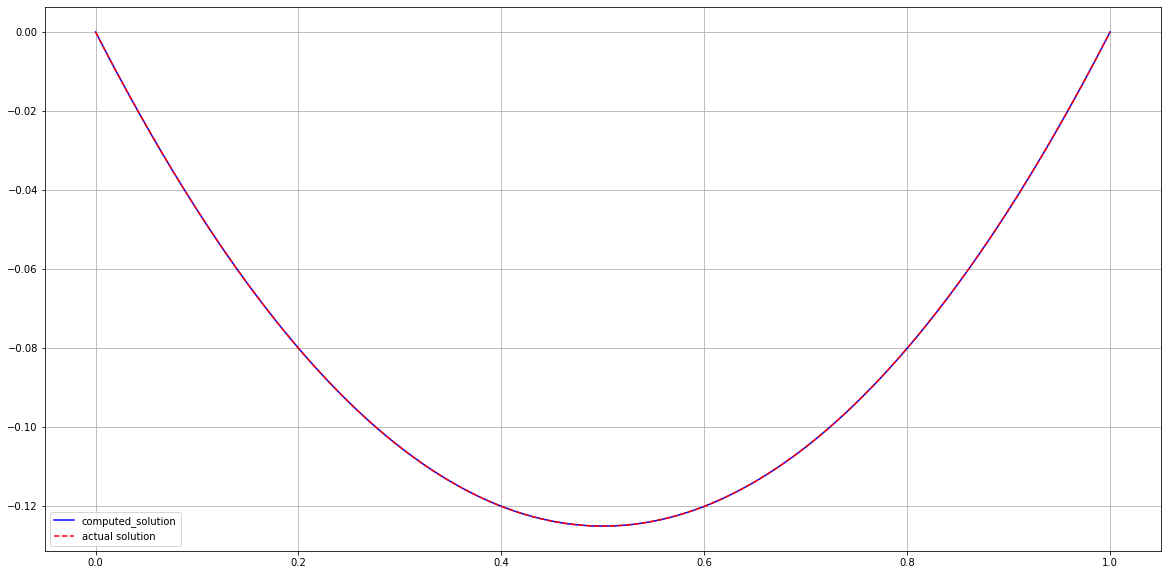

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(x_flat, u[:,0], 'b', label ='computed_solution')
plt.plot(x_flat, x_flat*(x_flat-1)/2, '--r', label ='actual solution')
plt.grid()
plt.legend()

# Discussion and Answers:

###(A) The loss-function in PINN consist of physics-informed loss and boundary loss. Write the expression for the physics-informed loss function and data-driven loss function for this problem.

- already explained this in the intro, the hyper-paramters we took for our model are as follows $N_x$ = 10000 and $\alpha = 1$.  
- expressions are available in the intro, please check the expressions from there the residual term is the physics loss and the rest is data driven loss.

###(B) Select a suitable activation function and justify your selection

- the activation we chose for the model was hyperbolic tangent, the function is continuous, centred and all order derivatives exist for every possible input and hence it is a good choice. 

###(C) Write a computer code to solve this problem.

- the code has been written above, it is based on the ideas given in the main paper and slides of the course but I wrote the code from scratch and didn't use the PINN code shown in the practical  as a template. 

###(D) The true solution of the above problem is $\frac{𝑥(𝑥 − 1)}{2}$. Plot and compare the PINN predicted results with the true solution.

- the results have been shown in the plot just above, as we can see that the model performs very well in this case as visually there is almost no error or vertical deviation between the showcased plots. 

- the red dashed curve is the actual solution and the solid blue line is the predicted curve or the computed solution. 
